In [ ]:
import numpy as np
import pandas as pd

from eval_utils import *
from model_evaluation import *

from sklearn.model_selection import GridSearchCV, KFold
from timeit import default_timer as timer

from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('train.csv')

df.columns = df.columns.str.strip().str.replace(" ", "_")

## Препроцессинг

Добавим признаки, полученные после feature engineering

In [2]:
def calculate_age_bins(df):
    """
    Бинаризирует группу дохода клиента
    """
    df["Income_Group"] = pd.qcut(df["Annual_Income"], q=4, labels=["Low Income", "Mid-Low", "Mid-High", "High Income"])    
    return df


def calculate_health_bins(df):
    """
    Бинаризирует рейтинг здоровья клиента
    """
    df["Health_Risk_Level"] = pd.qcut(df["Health_Score"], q=3, labels=["High Risk", "Medium Risk", "Low Risk"])
    
    return df

def create_age_features(df):
    """
    Добавляет взаимодействия признаков: возраст и рейтинг здоровья, возраст автомобиля и кол-во обращений клиента
    """
    df["Age_Health"] = df["Age"] * df["Health_Score"]

    df["VehicleAge_Claims"] = df["Vehicle_Age"] * df["Previous_Claims"]

    return df

def create_interaction_features(df):
    """
    Комбинация здоровья и предыдущих страховых случаев
    """
    df["Health_Claims"] = df["Health_Score"] * df["Previous_Claims"]

    return df

In [3]:
df["Policy_Start_Date"] = pd.to_datetime(df["Policy_Start_Date"])
df["Policy_Year"] = df["Policy_Start_Date"].dt.year
df["Policy_Month"] = df["Policy_Start_Date"].dt.month
df["Policy_Day"] = df["Policy_Start_Date"].dt.day

df_exp1 = calculate_age_bins(df)
df_exp2 = calculate_health_bins(df_exp1)
df_exp3 = create_age_features(df_exp2)
df_exp4 = create_interaction_features(df_exp3)

numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day',
    'Age_Health','VehicleAge_Claims','Health_Claims'
]

binary_features = ['Gender', 'Smoking_Status']
ordinal_features = ['Exercise_Frequency', 'Income_Group', 'Health_Risk_Level']
nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type'
]


X_train_proc4, X_test_proc4, y_train_exp4, y_test_exp4 = get_baseline_preprocessing(df_exp4, numerical_features, binary_features, ordinal_features, nominal_features)
exp4_results = run_experiment(X_train_proc4, X_test_proc4, y_train_exp4, y_test_exp4,
                                "Лучший результат (до подбора гипер-ов)")



ЭКСПЕРИМЕНТ: Лучший результат (до подбора гипер-ов)
Train shape: (960000, 44), Test shape: (240000, 44)
{'model': 'DecisionTreeRegressor', 'mse': 850734.2163904246, 'rmse': np.float64(922.3525445242858), 'mae': 622.3384728750603, 'r2': -0.13843252457547273, 'rmsle': np.float64(1.0501931560460038)}
{'model': 'RandomForestRegressor', 'mse': 859024.777805625, 'rmse': np.float64(926.8358958335747), 'mae': 624.5044803228972, 'r2': -0.1495267589206013, 'rmsle': np.float64(1.0582657693606974)}
{'model': 'XGBoost', 'mse': 856290.2717185869, 'rmse': np.float64(925.3595364606057), 'mae': 623.9089748776754, 'r2': -0.14586750717292585, 'rmsle': np.float64(1.050234893680564)}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1552
[LightGBM] [Info] Number of data points in the train set: 960000, n

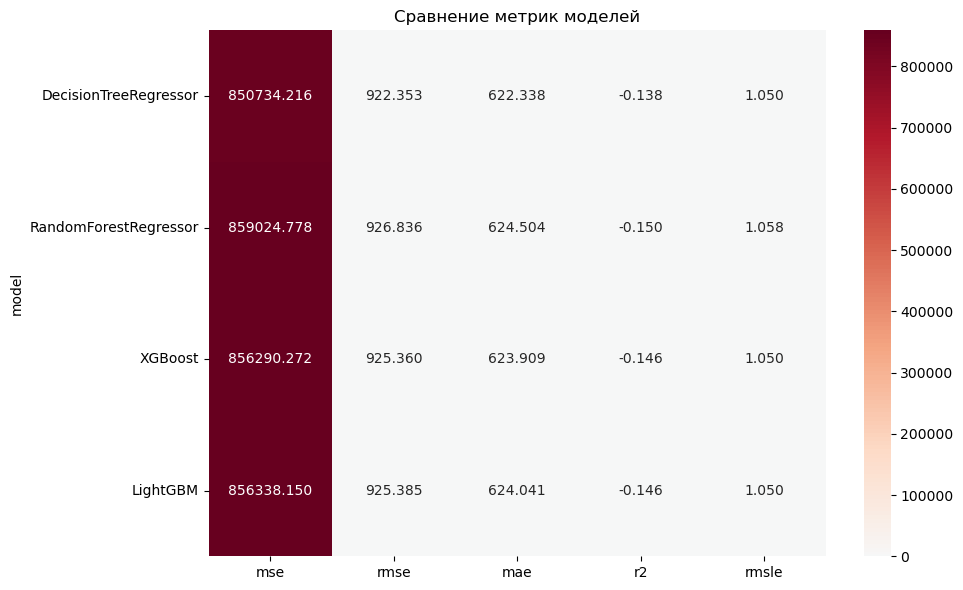

In [4]:
exp4_metrics = compare_models_metrics(exp4_results)

In [5]:
models = get_baseline_models()

In [6]:
models

{'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, random_state=42),
 'RandomForestRegressor': RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=20,
              n_jobs=None, num_parallel_tree=None, ...),
 'LightGBM': LGBMRegressor(max_dept

## GridSearchCV

Проведем подбор оптимальных гиперпараметров для модели XGBoost с помощью метода GridSearchCV, используя  кросс-валидацию (KFold) на 5 фолдов. Процесс будем оценивать по метрике RMSLE

In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
param_grid = {
    # 🔹 Контроль сложности модели и переобучения
    "XGBRegressor__max_depth": [3, 5, 7],             # Максимальная глубина дерева
    
    # 🔹 Скорость обучения и количество итераций бустинга
    "XGBRegressor__learning_rate": [0.05, 0.1],  # Скорость обучения
    "XGBRegressor__n_estimators": [40, 50, 100], # Количество деревьев (итераций)
    
    # 🔹 Регуляризация
    "XGBRegressor__reg_alpha": [0, 0.1, 1],   # L1-регуляризация (аналог lasсо)
    # "XGBRegressor__reg_lambda": [0, 0.1, 1],  # L2-регуляризация (аналог ридж)
    
    # 🔹 Сэмплирование данных и признаков (аналог bagging/feature_fraction)
    # "XGBRegressor__subsample": [0.7, 0.8, 1.0],         # Доля случайных примеров для каждого дерева
    "XGBRegressor__colsample_bytree": [0.7, 0.9, 1.0],  # Доля признаков для каждого дерева

}


grid_search = GridSearchCV(
    estimator=models['XGBoost'],
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=1,
    verbose=3
)

In [9]:
grid_search_start = timer()
grid_search.fit(X_train_proc4, y_train_exp4)
grid_search_end = timer()

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5] END XGBRegressor__colsample_bytree=0.7, XGBRegressor__learning_rate=0.05, XGBRegressor__max_depth=3, XGBRegressor__n_estimators=40, XGBRegressor__reg_alpha=0;, score=-1.050 total time=   1.1s
[CV 2/5] END XGBRegressor__colsample_bytree=0.7, XGBRegressor__learning_rate=0.05, XGBRegressor__max_depth=3, XGBRegressor__n_estimators=40, XGBRegressor__reg_alpha=0;, score=-1.049 total time=   1.2s
[CV 3/5] END XGBRegressor__colsample_bytree=0.7, XGBRegressor__learning_rate=0.05, XGBRegressor__max_depth=3, XGBRegressor__n_estimators=40, XGBRegressor__reg_alpha=0;, score=-1.049 total time=   1.4s
[CV 4/5] END XGBRegressor__colsample_bytree=0.7, XGBRegressor__learning_rate=0.05, XGBRegressor__max_depth=3, XGBRegressor__n_estimators=40, XGBRegressor__reg_alpha=0;, score=-1.051 total time=   1.2s
[CV 5/5] END XGBRegressor__colsample_bytree=0.7, XGBRegressor__learning_rate=0.05, XGBRegressor__max_depth=3, XGBRegressor__n_estimat

In [10]:
print(f"Total time: {grid_search_end - grid_search_start:.2f} seconds")

Total time: 983.04 seconds


In [11]:
grid_search.best_params_

{'XGBRegressor__colsample_bytree': 0.7,
 'XGBRegressor__learning_rate': 0.05,
 'XGBRegressor__max_depth': 3,
 'XGBRegressor__n_estimators': 40,
 'XGBRegressor__reg_alpha': 0}

In [27]:
grid_search.best_score_

np.float64(-1.0494001660597596)

По кросс-валидации видем улучшение целевой метрики RMSLE

In [ ]:
grid_search_best_model = grid_search.best_estimator_

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(
    grid_search.best_estimator_,
    X_train_proc4,
    y_train_exp4,
    scoring='neg_root_mean_squared_error',
    cv=5
)
print("Среднее по фолдам:", -np.mean(scores))

Среднее по фолдам: 1.0493823885081766


In [35]:
scores

array([-1.05184463, -1.0485755 , -1.04825479, -1.0473503 , -1.05101391])

In [34]:
metrics_grid = evaluate_model(grid_search_best_model, X_train_proc4, X_test_proc4, y_train_exp4, y_test_exp4, "XGBoost")

{'model': 'XGBoost', 'mse': 856290.2717185869, 'rmse': np.float64(925.3595364606057), 'mae': 623.9089748776754, 'r2': -0.14586750717292585, 'rmsle': np.float64(1.050234893680564)}


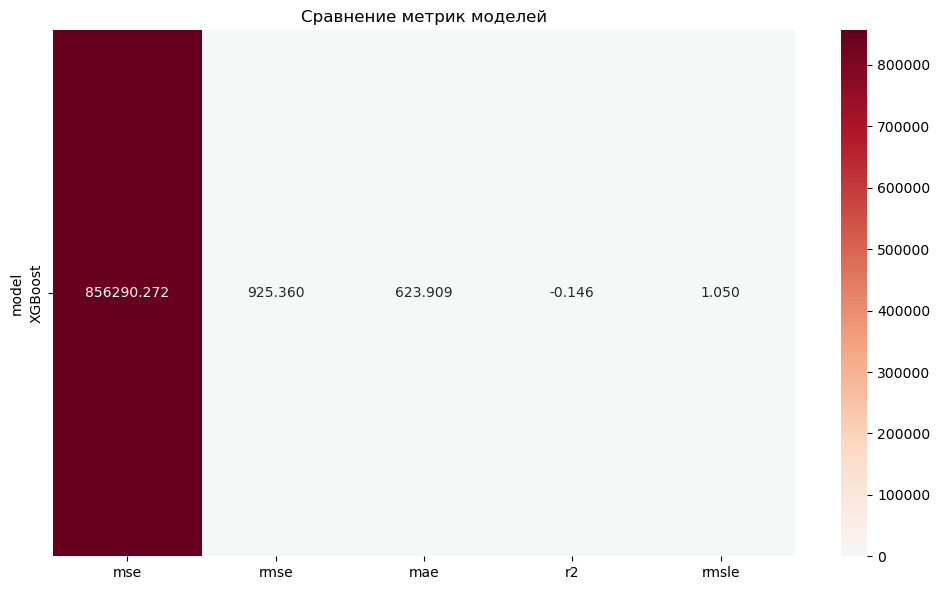

In [14]:
m = compare_models_metrics([metrics_grid])

In [25]:
exp4_metrics

,model,mse,rmse,mae,r2,rmsle
0,DecisionTreeRegressor,850734.216390,922.352545,622.338473,-0.138433,1.050193
1,RandomForestRegressor,859024.777806,926.835896,624.504480,-0.149527,1.058266
2,XGBoost,856290.271719,925.359536,623.908975,-0.145868,1.050235
3,LightGBM,856338.150327,925.385406,624.040997,-0.145932,1.050487


In [26]:
m

,model,mse,rmse,mae,r2,rmsle
0,XGBoost,856290.271719,925.359536,623.908975,-0.145868,1.050235


,mse,rmse,mae,r2,rmsle
model,,,,,
XGBoost,0.0,0.0,0.0,0.0,0.0


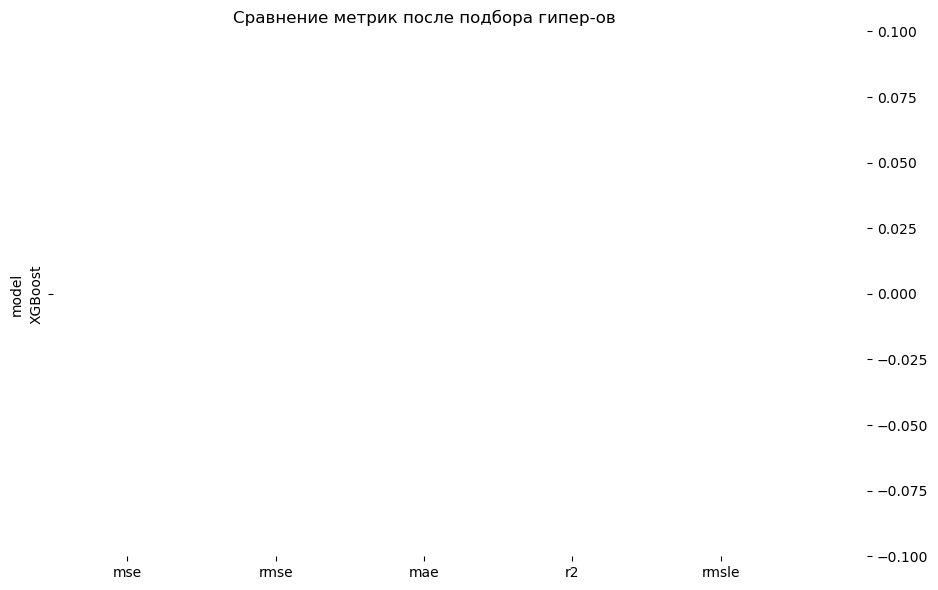

In [37]:
compare_after_add(m, exp4_metrics.iloc[[2]], 'Сравнение метрик после подбора гипер-ов')

Но при окончательном сравнении лучшей модели после подбора гиперпараметров, метрики почему то не изменились...

## BayesSearchCV

Проведем аналогичный подбор с помощью байесовской оптимизации (BayesSearchCV)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

param_space = {
    "max_depth": Integer(3, 7),
    "min_child_weight": Integer(1, 10),
    "learning_rate": Real(0.01, 0.1, prior='log-uniform'),
    "n_estimators": Integer(50, 300),
    "gamma": Real(0.0, 1.0, prior='uniform'),
    "reg_alpha": Real(1e-6, 1.0, prior='log-uniform'),
    "reg_lambda": Real(1e-6, 1.0, prior='log-uniform'),
    "subsample": Real(0.7, 1.0, prior='uniform'),
    "colsample_bytree": Real(0.7, 1.0, prior='uniform')
}


bayes_search = BayesSearchCV(
    estimator=XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42
    ),
    search_spaces=param_space,
    scoring='neg_root_mean_squared_error',  # RMSE по лог-таргету
    n_jobs=-1,
    cv=cv,
    n_iter=50,        
    random_state=42,
    verbose=3
)

bayes_start = timer()
bayes_search.fit(X_train_proc4, y_train_exp4)
bayes_end = timer()

print(f"Total time: {bayes_end - bayes_start:.2f} seconds")
print("Лучшие параметры:", bayes_search.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [41]:
bayes_search

BayesSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='rmse', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, i...
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=300, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=1e-06, high=1.0, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=1e-06, high=1.0, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.7, high=1.0, prior='uniform', transform='normalize')},
              verbose=3)

{'model': 'XGBoost', 'mse': 851307.2964204871, 'rmse': np.float64(922.6631543637619), 'mae': 621.540465656217, 'r2': -0.1391994067965452, 'rmsle': np.float64(1.0468975870027017)}


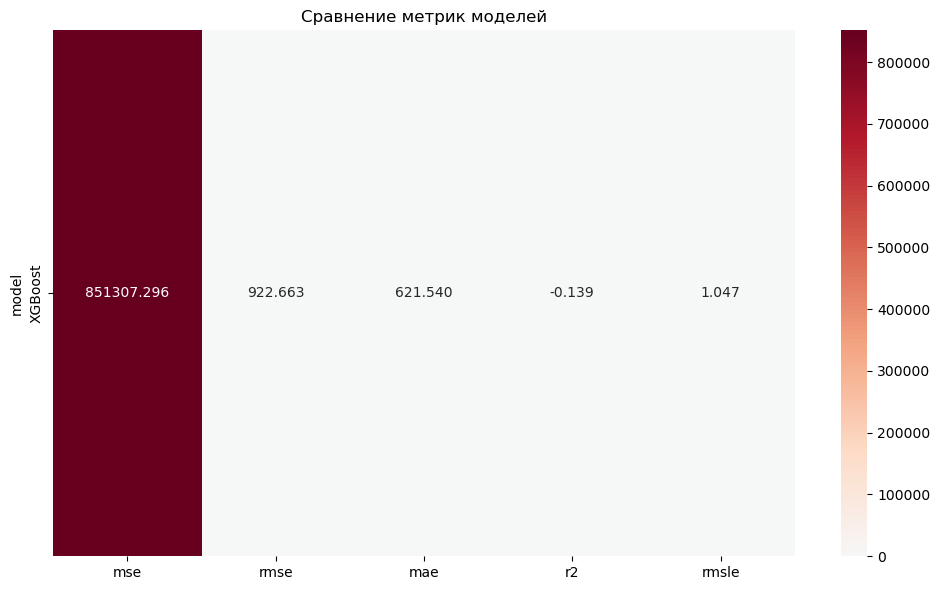

,mse,rmse,mae,r2,rmsle
model,,,,,
XGBoost,-4982.975298,-2.696382,-2.368509,0.006668,-0.003337


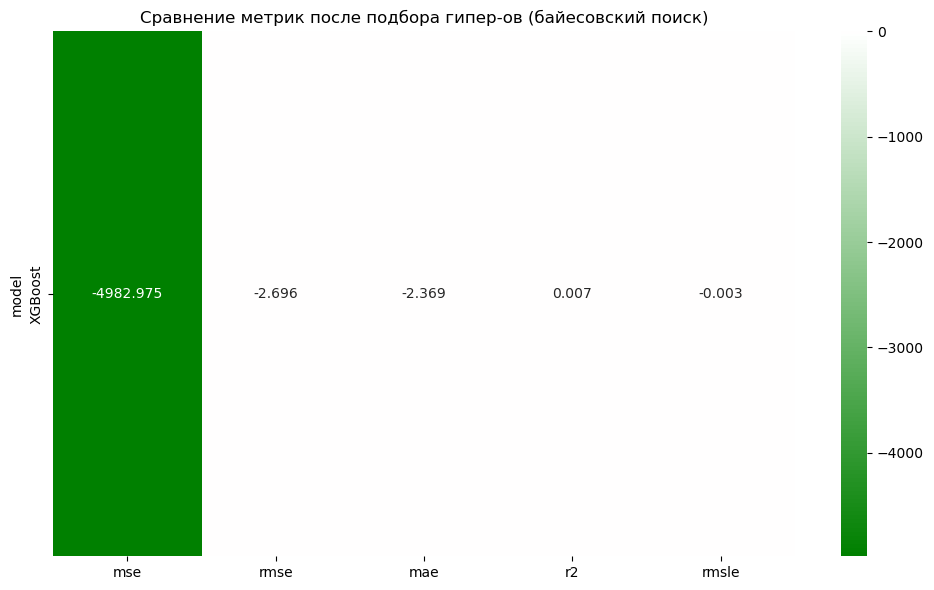

In [ ]:
metrics_bayes = evaluate_model(bayes_search.best_estimator_, X_train_proc4, X_test_proc4, y_train_exp4, y_test_exp4, "XGBoost")
m = compare_models_metrics([metrics_bayes])
compare_after_add(m, exp4_metrics.iloc[[2]], 'Сравнение метрик после подбора гипер-ов (байесовский поиск)',normalize=False)

В этом случае получили хоть и не совсем значительные, но какие то улучшения - снизился RMSE почти на 5 тыс. и RMSLE на 0.003

**Вывод**: таким образом, подбор гиперпараметров не дал каких то значимых изменений, снизился RMSLE на 0.003 и MSE на 5 тыс по отношению к модели XGBoost, которая была обучена после добавления новых признаков